In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('../', train=True, download=True, transform=transform), 
                                        batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('../', train=False, transform=transform), 
                                          batch_size=batch_size, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [9]:
def train(model, train_loader, optimizer, epoch, no_print=False):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if not no_print:
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))

In [10]:
def test(model, test_loader, no_print=False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    
    if not no_print:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [11]:
class Net_upd(nn.Module):
    def __init__(self, layers_num=6, size_n=1000, size_m=1000):
        super(Net_upd, self).__init__()
        self.layers_num = layers_num
        self.size_n = size_n
        self.size_m = size_m
        self.fc = nn.ModuleList()
        self.fc.append(nn.Linear(3 * 32 * 32, size_n))
        for i in range(1, layers_num-1):
            self.fc.append(nn.Linear(size_m, size_n))
        self.fc.append(nn.Linear(size_m, 10)) 
        self.ReLU = nn.ReLU()
    
    def forward(self, x):
        x = self.fc[0](x.view(-1, 3 * 32*32))
        x = self.ReLU(x)
        for i in range(1, self.layers_num-1):
            x = self.fc[i](x)
            x = self.ReLU(x)
        x = self.fc[self.layers_num-1](x)
        return F.log_softmax(x, dim=1)
    
    def get_layers(self):
        return self.fc

In [12]:
log_interval = 50
epochs = 10

In [13]:
model = Net_upd(epochs-2, 1000, 1000)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, epochs + 1):
    print(epoch)
    train(model,  train_loader, optimizer, epoch, False)
    test(model, test_loader, False)

1


/home/viga0114/Tools/anaconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.303619
Train Epoch: 1 [5000/50000 (10%)]	Loss: 2.043408
Train Epoch: 1 [10000/50000 (20%)]	Loss: 2.030388
Train Epoch: 1 [15000/50000 (30%)]	Loss: 1.813048
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.883153
Train Epoch: 1 [25000/50000 (50%)]	Loss: 1.951766
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.888239
Train Epoch: 1 [35000/50000 (70%)]	Loss: 1.864311
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.700777
Train Epoch: 1 [45000/50000 (90%)]	Loss: 1.801364

Test set: Average loss: 1.7222, Accuracy: 3613/10000 (36%)

2
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.487004
Train Epoch: 2 [5000/50000 (10%)]	Loss: 1.636249
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.653336
Train Epoch: 2 [15000/50000 (30%)]	Loss: 1.726930
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.604813
Train Epoch: 2 [25000/50000 (50%)]	Loss: 1.704237
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.529865
Train Epoch: 2 [35000/50000 (70%)]	Loss: 1.651959
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.756364

In [14]:
class CompressedNet_upd(nn.Module):
    def __init__(self, base, r):
        super(CompressedNet_upd, self).__init__()
        self.fc = nn.ModuleList()
        
        for i in range(len(base.fc)-1):
            fc_u, fc_s, fc_v = torch.svd( model.fc[i].weight.data)
            fc_u = torch.mm(fc_u[:,:r], torch.diag(fc_s[:r]))
            fc_v = fc_v.t()[:r,:]
        
            fc_1 = nn.Linear(model.fc[i].weight.shape[1], r, bias = False)
            fc_2 = nn.Linear(r, model.fc[i].weight.shape[0], bias=True)
            fc_1.weight = nn.Parameter(fc_v.clone().detach())
            fc_2.weight = nn.Parameter(fc_u.clone().detach())
            fc_2.bias.data.copy_(base.fc[i].bias.data)
            local_list = nn.ModuleList()
            local_list.append(fc_1)
            local_list.append(fc_2)
            self.fc.append(local_list)
        
        fc_last = nn.Linear(base.fc[-1].weight.shape[1], base.fc[-1].weight.shape[0])
        fc_last.weight.data.copy_( base.fc[-1].weight.data )
        fc_last.bias  .data.copy_( base.fc[-1].bias  .data )
        self.fc.append(fc_last)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = self.fc[0][0](x.view(-1, 3 * 32*32))
        x = self.fc[0][1](x)
        x = self.ReLU(x)
        for i in range(1, len(self.fc)-1):
            x = self.fc[i][0](x)
            x = self.fc[i][1](x)
            x = self.ReLU(x)
        x = self.fc[-1](x)
        return F.log_softmax(x, dim=1)

In [15]:
r_array = [5, 10, 20, 40, 80, 160, 400, 800, 1000]

In [16]:
acc_by_r = dict()
time_by_r = dict()

In [18]:
for r in r_array:
    model_compressed = CompressedNet_upd(model, r)
    acc = test(model_compressed, test_loader, True)
    result = %timeit -o test(model_compressed, test_loader, True)
    acc_by_r[r] = acc
    time_by_r[r] = result

3.31 s ± 156 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.53 s ± 402 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.46 s ± 177 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.55 s ± 232 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.59 s ± 137 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.93 s ± 282 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.87 s ± 221 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.69 s ± 1.44 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.66 s ± 483 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
import matplotlib.pyplot as plt

In [47]:
averages = [res.average for res in time_by_r.values()]
stdevs = [res.stdev for res in time_by_r.values()]
used_lambdas = [rate/10 for rate in r_array]
accs = [a for a in acc_by_r.values()]

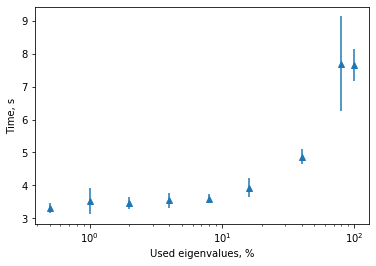

In [48]:
plt.errorbar(used_lambdas, averages, stdevs, linestyle='None', marker='^')
plt.xlabel("Used eigenvalues, %")
plt.ylabel("Time, s")
plt.xscale("log")
plt.show()

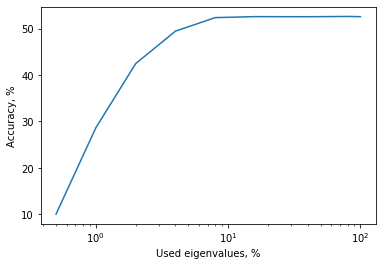

In [50]:
plt.plot(used_lambdas, accs)
plt.xlabel("Used eigenvalues, %")
plt.ylabel("Accuracy, %")
plt.xscale("log")
plt.show()